In [4]:
import numpy as np
import pandas as pd
from google.colab import files
file = files.upload()

Saving kepler_data.xlsx to kepler_data.xlsx


In [5]:
df = pd.read_excel("kepler_data.xlsx", skiprows= range(0,52))

In [3]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460.0,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0.0,0.0,0.0,0.0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460.0,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0.0,0.0,0.0,0.0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496.0,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0.0,0.0,0.0,0.0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459.0,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0.0,1.0,0.0,0.0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555.0,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0.0,0.0,0.0,0.0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   float64
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2360 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   float64
 7   koi_fpflag_ss      9564 non-null   float64
 8   koi_fpflag_co      9564 non-null   float64
 9   koi_fpflag_ec      9564 non-null   float64
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

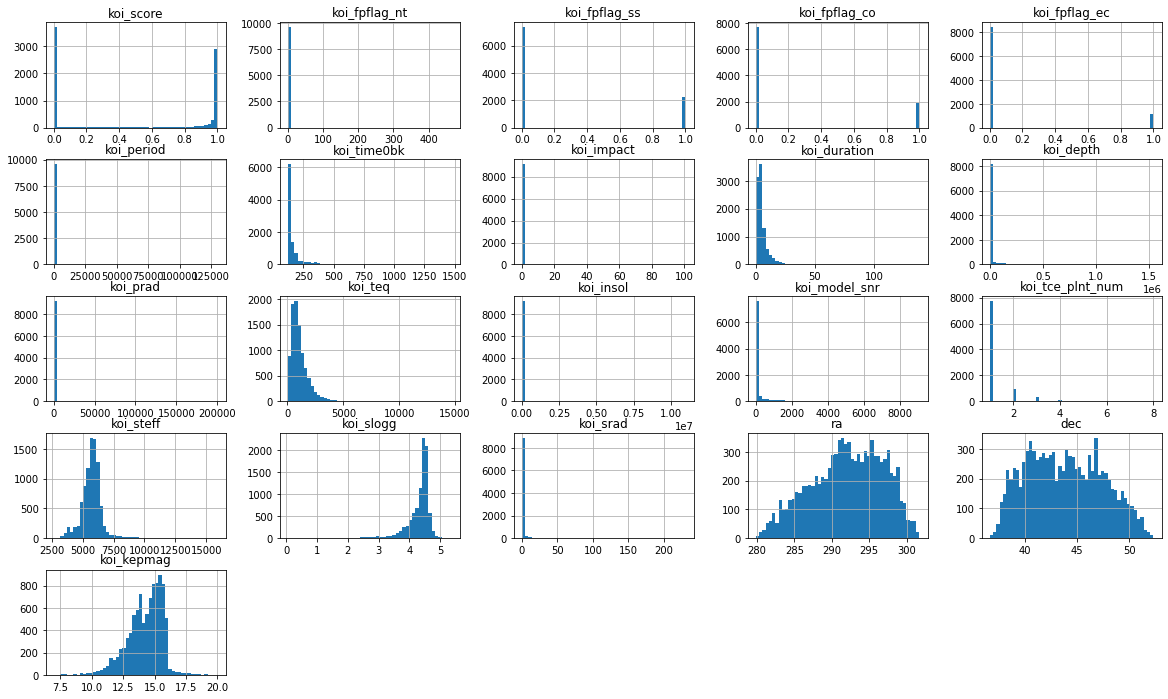

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
drop_list = ["kepid","kepoi_name","kepler_name","koi_tce_delivname"]
for col in df:
    if 'err' in col:
        drop_list.append(col)
df = df.drop(drop_list, axis=1)
# plotting histograms
df.hist(bins=50, figsize=(20,12))
plt.show()

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_attribs = []
df1 = df.drop("koi_disposition", axis = 1)
for label in df1:
    if (df1[label].dtype != np.number) and (df1[label].dtype != "int64"):
        cat_attribs += [label]
        
# getting numerical values  
num_attribs = df.select_dtypes(include=['int64', 'float64']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=float("NaN"),strategy="mean")),
    ('scaler', StandardScaler()),])
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
print(cat_attribs)

['koi_pdisposition']


In [8]:
print(full_pipeline)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg',
       'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')),
                                ('cat', OneHotEncoder(), ['koi_pdisposition'])])


In [9]:
df['koi_disposition'].value_counts()

FALSE POSITIVE    4840
CANDIDATE         2366
CONFIRMED         2358
Name: koi_disposition, dtype: int64

In [8]:
from sklearn.preprocessing import LabelBinarizer
y = df['koi_disposition']
y_dense = LabelBinarizer().fit_transform(y)
print(len(y_dense))

9564


In [17]:
print(len(df))

9564


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop("koi_disposition", axis=1), y, test_size = 0.2, random_state =42)
X_train

,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
8117,FALSE POSITIVE,0.000,1.0,0.0,1.0,1.0,0.580725,131.729560,0.2920,1.8200,64.2,0.75,2191.0,5418.89,16.9,1.0,5989.0,4.492,0.933,282.15744,43.689152,14.569
5245,CANDIDATE,0.997,0.0,0.0,0.0,0.0,14.532605,140.468500,0.1120,2.4212,328.9,1.69,746.0,73.37,29.0,1.0,6003.0,4.507,0.932,285.71191,49.706661,13.785
5865,FALSE POSITIVE,1.000,0.0,0.0,1.0,0.0,1.339670,132.167860,0.6020,1.8950,28.6,1.27,3448.0,33385.02,21.7,1.0,8867.0,3.988,2.245,297.19012,40.027969,10.455
4050,FALSE POSITIVE,0.000,0.0,1.0,1.0,0.0,160.412202,262.400220,0.9030,4.9200,2538.0,4.45,270.0,1.26,24.4,1.0,5269.0,4.620,0.727,293.20773,41.698582,15.407
5130,CANDIDATE,0.996,0.0,0.0,0.0,0.0,11.937835,133.261200,0.0360,4.6520,246.0,1.15,671.0,47.91,9.6,1.0,5469.0,4.611,0.738,296.65256,46.618809,15.954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,FALSE POSITIVE,0.000,0.0,0.0,1.0,0.0,2.399082,133.064250,1.2760,4.3840,6071.6,40.60,1360.0,810.78,89.9,1.0,5780.0,4.438,1.000,298.57697,40.490395,16.494
5191,CANDIDATE,0.967,0.0,0.0,0.0,0.0,82.175197,197.201870,0.0150,8.6640,546.4,2.24,441.0,8.92,20.8,1.0,6247.0,4.489,0.954,295.94827,44.753120,15.292
5390,FALSE POSITIVE,0.000,0.0,1.0,1.0,1.0,1.195515,132.303851,1.2810,5.0834,8054.4,49.33,1959.0,3469.70,309.1,1.0,6040.0,4.271,1.155,297.54337,41.947979,13.998
860,CANDIDATE,1.000,0.0,0.0,0.0,0.0,6.230335,181.295660,0.8080,1.6493,1449.2,3.70,875.0,138.33,31.6,1.0,5477.0,4.557,0.865,284.20966,45.258080,15.977


In [19]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [20]:
print(len(X_train_prepared))

7651


In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
knn = KNeighborsClassifier()
param_dist = {'n_neighbors': list(range(1,100))}
Search = RandomizedSearchCV(knn, param_distributions = param_dist)
Search.fit(X_train_prepared, y_train)
print(Search.best_estimator_)

KNeighborsClassifier(n_neighbors=41)


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def print_metrics(test, predictions, name):
  acc = accuracy_score(test, predictions)
  prec = precision_score(test, predictions, average= "weighted")
  rec = recall_score(test, predictions, average="weighted")
  f1 = f1_score(test, predictions, average="weighted")

  print(name)
  print(f"Accuracy Score is {acc}")
  print(f"Precision Score is {prec}")
  print(f"Recall Score is {rec}")
  print(f"F1_Score is {f1}")

In [51]:
X_test_prepared = full_pipeline.fit_transform(X_test)
y_pred = Search.predict(X_test_prepared)
print_metrics(y_test, y_pred, "KNN")

KNN
Accuracy Score is 0.8389963408259279
Precision Score is 0.8517229958209445
Recall Score is 0.8389963408259279
F1_Score is 0.8326647364755163


In [67]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
param_dist_1 = {'max_depth': list(range(1,9)), 'min_samples_leaf':list(range(3,8)),'max_features':list(range(7,18)),'min_samples_split':list(range(2,7))}
Search_tree = RandomizedSearchCV(dtc, param_distributions = param_dist_1)
y_train_label = LabelBinarizer().fit_transform(y_train)
Search_tree.fit(X_train_prepared, y_train)
print(Search_tree.best_estimator_)

DecisionTreeClassifier(max_depth=6, max_features=17, min_samples_leaf=6,
                       min_samples_split=4)


In [68]:
y_pred_tree = Search_tree.predict(X_test_prepared)
y_test_label = LabelBinarizer().fit_transform(y_test)
print_metrics(y_test, y_pred_tree, "DecisionTreeClassifier")

DecisionTreeClassifier
Accuracy Score is 0.861996863565081
Precision Score is 0.8960258780790791
Recall Score is 0.861996863565081
F1_Score is 0.8535277023836


In [80]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

svm = SVC(random_state=42)
svm.fit(X_train_prepared, y_train)
y_pred_svm = svm.predict(X_test_prepared)
print_metrics(y_test, y_pred_svm, "SVM")



SVM
Accuracy Score is 0.8515420805018296
Precision Score is 0.8695246506987565
Recall Score is 0.8515420805018296
F1_Score is 0.8443503804059787


In [79]:
svm2 = SVC(random_state=42)
clf = OneVsOneClassifier(svm2)
clf.fit(X_train_prepared, y_train)
y_pred_ovo = clf.predict(X_test_prepared)
print_metrics(y_test, y_pred_ovo, "SVM one vs one")

SVM one vs one
Accuracy Score is 0.8525875588081547
Precision Score is 0.8683895781848603
Recall Score is 0.8525875588081547
F1_Score is 0.8460979518045811


In [82]:
svm3 = SVC(random_state=42)
param_dist_3 = {'C':list(range(1,5)),'kernel':['linear','poly','rbf'],'degree':list(range(2,7))}
Search_svc = RandomizedSearchCV(svm3, param_distributions= param_dist_3)
Search_svc.fit(X_train_prepared, y_train)
print(Search_svc.best_estimator_)

SVC(C=3, degree=4, random_state=42)


In [83]:
y_pred_svc = Search_svc.predict(X_test_prepared)
print_metrics(y_test, y_pred_svc, "SVC")

SVC
Accuracy Score is 0.8520648196549921
Precision Score is 0.865245715393427
Recall Score is 0.8520648196549921
F1_Score is 0.8464351623553834
